#1.1 Printing Threads and Blocks
These exercises will have you write some basic CUDA applications. You will learn how to allocate GPU memory, move data between the host and the GPU, and launch kernels.

1. Hello World
Your first task is to create a simple hello world application in CUDA. The code skeleton is already given to you in hello.cu. Edit that file, paying attention to the FIXME locations, so that the output when run is like this:

`Hello from block: 0, thread: 0`

`Hello from block: 0, thread: 1`

`Hello from block: 1, thread: 0`

`Hello from block: 1, thread: 1`

(the ordering of the above lines may vary; ordering differences do not indicate an incorrect result)

Note the use of cudaDeviceSynchronize() after the kernel launch. In CUDA, kernel launches are asynchronous to the host thread. The host thread will launch a kernel but not wait for it to finish, before proceeding with the next line of host code. Therefore, to prevent application termination before the kernel gets to print out its message, we must use this synchronization function.

After editing the code, compile it using the following:

module load cuda
nvcc -o hello hello.cu
The module load command selects a CUDA compiler for your use. The module load command only needs to be done once per session/login. nvcc is the CUDA compiler invocation command. The syntax is generally similar to gcc/g++.

If you have trouble, you can look at hello_solution.cu for a complete example.

To run your code at OLCF on Summit, we will use an LSF command:

bsub -W 10 -nnodes 1 -P <allocation_ID> -Is jsrun -n1 -a1 -c1 -g1 ./hello
Alternatively, you may want to create an alias for your bsub command in order to make subsequent runs easier:

alias lsfrun='bsub -W 10 -nnodes 1 -P <allocation_ID> -Is jsrun -n1 -a1 -c1 -g1'
lsfrun ./hello
To run your code at NERSC on Cori, we can use Slurm:

module load esslurm
srun -C gpu -N 1 -n 1 -t 10 -A m3502 --gres=gpu:1 -c 10 ./hello
Allocation m3502 is a custom allocation set up on Cori for this training series, and should be available to participants who registered in advance until January 18, 2020. If you cannot submit using this allocation, but already have access to another allocation that grants access to the Cori GPU nodes, you may use that instead.

If you prefer, you can instead reserve a GPU in an interactive session, and then run an executable any number of times while the Slurm allocation is active:

salloc -C gpu -N 1 -t 60 -A m3502 --gres=gpu:1 -c 10
srun -n 1 ./hello
Note that you only need to module load esslurm once per login session; this is what enables you to submit to the Cori GPU nodes.



# hello.cu

 include <stdio.h>

__global__ void hello(){

  printf("Hello from block: %u, thread: %u\n", FIXME);
}

int main(){

  hello<<<FIXME>>>();
  cudaDeviceSynchronize();
}


In [ ]:


%%writefile hello.cu

# include <stdio.h>

__global__ void hello(){

  printf("Hello from block: %u, thread: %u\n", blockIdx.x, threadIdx.x);
}

int main(){
  hello<<<2,2>>>();
  cudaDeviceSynchronize();
  return 0; //Add return statement to main function.
}


Writing hello.cu


In [ ]:
!nvcc  hello.cu -o hello
!./hello

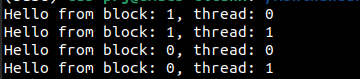

# 1.2 Vector Addition

If you're up for a challenge, see if you can write a complete vector add program from scratch. Or if you prefer, there is a skeleton code given to you in `vector_add.cu`. Edit the code to build a complete vector_add program. Compile it and run it similar to the method given in exercise 1. You can refer to `vector_add_solution.cu` for a complete example.

Note that this skeleton code includes something we didn't cover in lesson 1: CUDA error checking. Every CUDA runtime API call returns an error code. It's good practice (especially if you're having trouble) to rigorously check these error codes. A macro is given that will make this job easier. Note the special error checking method after a kernel call.

Typical output when complete would look like this:

`A[0] = 0.840188`

`B[0] = 0.394383`

`C[0] = 1.234571`

##vector_add.cu



```
#include <stdio.h>

// error checking macro
#define cudaCheckErrors(msg) \
    do { \
        cudaError_t __err = cudaGetLastError(); \
        if (__err != cudaSuccess) { \
            fprintf(stderr, "Fatal error: %s (%s at %s:%d)\n", \
                msg, cudaGetErrorString(__err), \
                __FILE__, __LINE__); \
            fprintf(stderr, "*** FAILED - ABORTING\n"); \
            exit(1); \
        } \
    } while (0)


const int DSIZE = 4096;
const int block_size = 256;  // CUDA maximum is 1024
// vector add kernel: C = A + B
__global__ void vadd(const float *A, const float *B, float *C, int ds){

  int idx = FIXME // create typical 1D thread index from built-in variables
  if (idx < ds)
    FIXME         // do the vector (element) add here
}

int main(){

  float *h_A, *h_B, *h_C, *d_A, *d_B, *d_C;
  h_A = new float[DSIZE];  // allocate space for vectors in host memory
  h_B = new float[DSIZE];
  h_C = new float[DSIZE];
  for (int i = 0; i < DSIZE; i++){  // initialize vectors in host memory
    h_A[i] = rand()/(float)RAND_MAX;
    h_B[i] = rand()/(float)RAND_MAX;
    h_C[i] = 0;}
  cudaMalloc(&d_A, DSIZE*sizeof(float));  // allocate device space for vector A
  FIXME // allocate device space for vector B
  FIXME // allocate device space for vector C
  cudaCheckErrors("cudaMalloc failure"); // error checking
  // copy vector A to device:
  cudaMemcpy(d_A, h_A, DSIZE*sizeof(float), cudaMemcpyHostToDevice);
  // copy vector B to device:
  FIXME
  cudaCheckErrors("cudaMemcpy H2D failure");
  //cuda processing sequence step 1 is complete
  vadd<<<(DSIZE+block_size-1)/block_size, block_size>>>(d_A, d_B, d_C, DSIZE);
  cudaCheckErrors("kernel launch failure");
  //cuda processing sequence step 2 is complete
  // copy vector C from device to host:
  FIXME
  //cuda processing sequence step 3 is complete
  cudaCheckErrors("kernel execution failure or cudaMemcpy H2D failure");
  printf("A[0] = %f\n", h_A[0]);
  printf("B[0] = %f\n", h_B[0]);
  printf("C[0] = %f\n", h_C[0]);
  return 0;
}
  
```


  

In [ ]:
%%writefile vector_add.cu

#include <stdio.h>

// error checking macro
#define cudaCheckErrors(msg) \
    do { \
        cudaError_t __err = cudaGetLastError(); \
        if (__err != cudaSuccess) { \
            fprintf(stderr, "Fatal error: %s (%s at %s:%d)\n", \
                msg, cudaGetErrorString(__err), \
                __FILE__, __LINE__); \
            fprintf(stderr, "*** FAILED - ABORTING\n"); \
            exit(1); \
        } \
    } while (0)


const int DSIZE = 4096;
const int block_size = 256;  // CUDA maximum is 1024
// vector add kernel: C = A + B
__global__ void vadd(const float *A, const float *B, float *C, int ds){

  int idx = threadIdx.x+blockDim.x*blockIdx.x;
  if (idx < ds)
    C[idx] = A[idx] + B[idx];
}

int main(){

  float *h_A, *h_B, *h_C, *d_A, *d_B, *d_C;
  h_A = new float[DSIZE];
  h_B = new float[DSIZE];
  h_C = new float[DSIZE];
  for (int i = 0; i < DSIZE; i++){
    h_A[i] = rand()/(float)RAND_MAX;
    h_B[i] = rand()/(float)RAND_MAX;
    h_C[i] = 0;}
  cudaMalloc(&d_A, DSIZE*sizeof(float));
  cudaMalloc(&d_B, DSIZE*sizeof(float));
  cudaMalloc(&d_C, DSIZE*sizeof(float));
  cudaCheckErrors("cudaMalloc failure");
  cudaMemcpy(d_A, h_A, DSIZE*sizeof(float), cudaMemcpyHostToDevice);
  cudaMemcpy(d_B, h_B, DSIZE*sizeof(float), cudaMemcpyHostToDevice);
  cudaCheckErrors("cudaMemcpy H2D failure");
  //cuda processing sequence step 1 is complete
  vadd<<<(DSIZE+block_size-1)/block_size, block_size>>>(d_A, d_B, d_C, DSIZE);
  cudaCheckErrors("kernel launch failure");
  //cuda processing sequence step 2 is complete
  cudaMemcpy(h_C, d_C, DSIZE*sizeof(float), cudaMemcpyDeviceToHost);
  //cuda processing sequence step 3 is complete
  cudaCheckErrors("kernel execution failure or cudaMemcpy H2D failure");
  printf("A[0] = %f\n", h_A[0]);
  printf("B[0] = %f\n", h_B[0]);
  printf("C[0] = %f\n", h_C[0]);
  return 0;
}


Writing vector_add.cu


In [ ]:
!nvcc -arch=sm_75 vector_add.cu -o vector_add
#need to specify -arch = sm_75 for tesla gpus and my nvcc is 11.8 - not compatible with 12 version.


In [ ]:
!./vector_add

A[0] = 0.840188
B[0] = 0.394383
C[0] = 1.234571


In [ ]:
!nvcc --ptxas-options=-v vector_add.cu -o vector_add


ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function '_Z4vaddPKfS0_Pfi' for 'sm_52'
ptxas info    : Function properties for _Z4vaddPKfS0_Pfi
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 8 registers, 348 bytes cmem[0]


#1.3 Matrix Multiply (naive)

A skeleton naive matrix multiply is given to you in matrix_mul.cu. See if you can complete it to get a correct result. If you need help, you can refer to matrix_mul_solution.cu.

This example introduces 2D threadblock/grid indexing, something we did not cover in lesson 1. If you study the code you will probably be able to see how it is a structural extension from the 1D case.

This code includes built-in error checking, so a correct result is indicated by the program.

##matrix_multiply.cu

```
#include <stdio.h>

// these are just for timing measurments
#include <time.h>

// error checking macro
#define cudaCheckErrors(msg) \
    do { \
        cudaError_t __err = cudaGetLastError(); \
        if (__err != cudaSuccess) { \
            fprintf(stderr, "Fatal error: %s (%s at %s:%d)\n", \
                msg, cudaGetErrorString(__err), \
                __FILE__, __LINE__); \
            fprintf(stderr, "*** FAILED - ABORTING\n"); \
            exit(1); \
        } \
    } while (0)


const int DSIZE = 4096;
const int block_size = 16;  // CUDA maximum is 1024 *total* threads in block
const float A_val = 1.0f;
const float B_val = 2.0f;

// matrix multiply (naive) kernel: C = A * B
__global__ void mmul(const float *A, const float *B, float *C, int ds) {

  int idx = threadIdx.x+blockDim.x*blockIdx.x; // create thread x index
  int idy = threadIdx.y+blockDim.y*blockIdx.y; // create thread y index

  if ((idx < ds) && (idy < ds)){
    float temp = 0;
    for (int i = 0; i < ds; i++)
      temp += A[FIXME*ds+i] * B[i*ds+FIXME];   // dot product of row and column
    C[idy*ds+idx] = temp;
  }
}

int main(){

  float *h_A, *h_B, *h_C, *d_A, *d_B, *d_C;

  // these are just for timing
  clock_t t0, t1, t2;
  double t1sum=0.0;
  double t2sum=0.0;

  // start timing
  t0 = clock();

  h_A = new float[DSIZE*DSIZE];
  h_B = new float[DSIZE*DSIZE];
  h_C = new float[DSIZE*DSIZE];
  for (int i = 0; i < DSIZE*DSIZE; i++){
    h_A[i] = A_val;
    h_B[i] = B_val;
    h_C[i] = 0;}

  // Initialization timing
  t1 = clock();
  t1sum = ((double)(t1-t0))/CLOCKS_PER_SEC;
  printf("Init took %f seconds.  Begin compute\n", t1sum);

  // Allocate device memory and copy input data over to GPU
  cudaMalloc(&d_A, DSIZE*DSIZE*sizeof(float));
  cudaMalloc(&d_B, DSIZE*DSIZE*sizeof(float));
  cudaMalloc(&d_C, DSIZE*DSIZE*sizeof(float));
  cudaCheckErrors("cudaMalloc failure");
  cudaMemcpy(d_A, h_A, DSIZE*DSIZE*sizeof(float), cudaMemcpyHostToDevice);
  cudaMemcpy(d_B, h_B, DSIZE*DSIZE*sizeof(float), cudaMemcpyHostToDevice);
  cudaCheckErrors("cudaMemcpy H2D failure");

  // Cuda processing sequence step 1 is complete

  // Launch kernel
  dim3 block(block_size, block_size);  // dim3 variable holds 3 dimensions
  dim3 grid((DSIZE+block.x-1)/block.x, (DSIZE+block.y-1)/block.y);
  mmul<<<grid, block>>>(d_A, d_B, d_C, DSIZE);
  cudaCheckErrors("kernel launch failure");

  // Cuda processing sequence step 2 is complete

  // Copy results back to host
  cudaMemcpy(h_C, d_C, DSIZE*DSIZE*sizeof(float), cudaMemcpyDeviceToHost);

  // GPU timing
  t2 = clock();
  t2sum = ((double)(t2-t1))/CLOCKS_PER_SEC;
  printf ("Done. Compute took %f seconds\n", t2sum);

  // Cuda processing sequence step 3 is complete

  // Verify results
  cudaCheckErrors("kernel execution failure or cudaMemcpy H2D failure");
  for (int i = 0; i < DSIZE*DSIZE; i++) if (h_C[i] != A_val*B_val*DSIZE) {printf("mismatch at index %d, was: %f, should be: %f\n", i, h_C[i], A_val*B_val*DSIZE); return -1;}
  printf("Success!\n");

  return 0;
}
  


```






  

In [1]:

%%writefile matrix_multiply.cu
# include <stdio.h>

// these are just for timing measurments
# include <time.h>

// error checking macro
# define cudaCheckErrors(msg) \
    do { \
        cudaError_t __err = cudaGetLastError(); \
        if (__err != cudaSuccess) { \
            fprintf(stderr, "Fatal error: %s (%s at %s:%d)\n", \
                msg, cudaGetErrorString(__err), \
                __FILE__, __LINE__); \
            fprintf(stderr, "*** FAILED - ABORTING\n"); \
            exit(1); \
        } \
    } while (0)


const int DSIZE = 8192;
const int block_size = 32;  // CUDA maximum is 1024 *total* threads in block
const float A_val = 3.0f;
const float B_val = 2.0f;

// matrix multiply (naive) kernel: C = A * B
__global__ void mmul(const float *A, const float *B, float *C, int ds) {

  int idx = threadIdx.x+blockDim.x*blockIdx.x; // create thread x index
  int idy = threadIdx.y+blockDim.y*blockIdx.y; // create thread y index

  if ((idx < ds) && (idy < ds)){
    float temp = 0;
    for (int i = 0; i < ds; i++)
      temp += A[idy*ds+i] * B[i*ds+idx];   // dot product of row and column
    C[idy*ds+idx] = temp;
  }
}

int main(){

  float *h_A, *h_B, *h_C, *d_A, *d_B, *d_C;

  // these are just for timing
  clock_t t0, t1, t2;
  double t1sum=0.0;
  double t2sum=0.0;

  // start timing
  t0 = clock();

  h_A = new float[DSIZE*DSIZE];
  h_B = new float[DSIZE*DSIZE];
  h_C = new float[DSIZE*DSIZE];
  for (int i = 0; i < DSIZE*DSIZE; i++){
    h_A[i] = A_val;
    h_B[i] = B_val;
    h_C[i] = 0;}

  // Initialization timing
  t1 = clock();
  t1sum = ((double)(t1-t0))/CLOCKS_PER_SEC;
  printf("Init took %f seconds.  Begin compute\n", t1sum);

  // Allocate device memory and copy input data over to GPU
  cudaMalloc(&d_A, DSIZE*DSIZE*sizeof(float));
  cudaMalloc(&d_B, DSIZE*DSIZE*sizeof(float));
  cudaMalloc(&d_C, DSIZE*DSIZE*sizeof(float));
  cudaCheckErrors("cudaMalloc failure");
  cudaMemcpy(d_A, h_A, DSIZE*DSIZE*sizeof(float), cudaMemcpyHostToDevice);
  cudaMemcpy(d_B, h_B, DSIZE*DSIZE*sizeof(float), cudaMemcpyHostToDevice);
  cudaCheckErrors("cudaMemcpy H2D failure");

  // Cuda processing sequence step 1 is complete

  // Launch kernel
  dim3 block(block_size, block_size);  // dim3 variable holds 3 dimensions
  dim3 grid((DSIZE+block.x-1)/block.x, (DSIZE+block.y-1)/block.y);
  mmul<<<grid, block>>>(d_A, d_B, d_C, DSIZE);
  cudaCheckErrors("kernel launch failure");

  // Cuda processing sequence step 2 is complete

  // Copy results back to host
  cudaMemcpy(h_C, d_C, DSIZE*DSIZE*sizeof(float), cudaMemcpyDeviceToHost);

  // GPU timing
  t2 = clock();
  t2sum = ((double)(t2-t1))/CLOCKS_PER_SEC;
  printf ("Done. Compute took %f seconds\n", t2sum);

  // Cuda processing sequence step 3 is complete

  // Verify results
  cudaCheckErrors("kernel execution failure or cudaMemcpy H2D failure");
  for (int i = 0; i < DSIZE*DSIZE; i++) if (h_C[i] != A_val*B_val*DSIZE) {printf("mismatch at index %d, was: %f, should be: %f\n", i, h_C[i], A_val*B_val*DSIZE); return -1;}
  printf("Success!\n");

  return 0;
}


Writing matrix_multiply.cu


In [2]:
!nvcc -arch=sm_75 matrix_multiply.cu -o matrix_multiply

In [3]:
!./matrix_multiply

Init took 0.691415 seconds.  Begin compute
Done. Compute took 2.102869 seconds
Success!
